In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as anim
from scipy import stats
from scipy.optimize import curve_fit
import os 
import seaborn as sns
sns.set_palette('flare')
interval=10

In [2]:


def func_exp(x, a, b):
    return a * np.exp(-b * x) 

def get_data_pos(n):
	files = os.listdir('positions'+str(n))
	files = [file for file in files if file.endswith('.bin')]

	with open('config'+str(n)+'.txt','r') as f:
		lines = [float(line) for line in f.readlines()]


	print(lines)
	t_max = lines[0]
	dt=lines[1]
	V0=lines[2]
	T=lines[3]
	
	return files, t_max, dt, V0, T

def get_data_vel(n):

	files = os.listdir('velocities'+str(n))
	files = [file for file in files if file.endswith('.bin')]

	with open('config'+str(n)+'.txt','r') as f:
		lines = [float(line) for line in f.readlines()]


	print(lines)
	t_max = lines[0]
	dt=lines[1]
	V0=lines[2]
	T=lines[3]
	
	return files, t_max, dt, V0, T

def import_data(files,n,t_max,type='positions'):
	# Import data
	data = []
	for file in files:
		with open(type+str(n)+'/'+file,'rb') as f:
			data.append(np.fromfile(f,dtype=np.float64))


	time=np.linspace(0,t_max,len(data[0]))
	return data,time

def graph_all_position(data_array,time,skips=1, colour_range=False,text='Posición'):
	plt.figure(figsize=(12,5),dpi=300)
	ii=0
	N=len(data_array)
	for data in data_array:
		ii+=1
		if colour_range:
			hsv=((N-ii)/N,1,0.4)
			plt.plot(time[::skips],data[::skips],color=mcolors.hsv_to_rgb(hsv))
		else:
			plt.plot(time[::skips],data[::skips])


	plt.xlabel('Tiempo')
	plt.ylabel(text)
	plt.title(text+' de las partículas en el tiempo')

def varianza(particle_positions,time,temp):


	variance_at_each_time = np.var(particle_positions, axis=0)

	coeffs = np.polyfit(time, variance_at_each_time, 1)
	fitted_data = coeffs[0] * time + coeffs[1]

	plt.figure(dpi=100)


	slope, intercept, r_value, p_value, std_err = stats.linregress(time, variance_at_each_time)

	# slope=2DT
	D_a=slope/(2*temp)
	print("D=",D_a)

	print('slope =', slope)
	print('intercept =', intercept)
	print('r_value =', r_value)
	print('p_value =', p_value)
	print('std_err =', std_err)
	scale=0.5
	plt.figure(dpi=300,figsize=(16*scale,9*scale))
	plt.text(0.05, 0.95, f'$\sigma^2$ = {coeffs[0]:.2f}x + {coeffs[1]:.2f}\nD={D_a:.3f}  $R^2=${r_value*r_value:.4f}', transform=plt.gca().transAxes, 
			fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

	plt.plot(time,fitted_data, label='Fitted line',color='black')
	plt.plot(time,variance_at_each_time,linewidth=0.8,color='red')
	plt.title("Varianza como función del tiempo")
	plt.xlabel("Tiempo")
	plt.ylabel("Varianza")

	return slope, intercept, variance_at_each_time


def gaussian(mu,sigma,x,N_particles):
	if sigma<=0:
		return np.zeros(len(x))
	return np.exp(
		-0.5*(((x-mu)/sigma)**2)
			   )*(1/(sigma*np.sqrt(2*np.pi)))*N_particles

def animar_histograma(posiciones,time,t_max,slope,intercept,variance_at_each_time,filename,frame_number=30):
	last_postion=posiciones[:, -1]
	N_particles=len(last_postion)
	plt.rcParams['text.color'] = 'w'
	plt.rcParams['axes.labelcolor'] = 'w'

	fig, ax = plt.subplots()
	fig.set_dpi(300)
	bin_size = 1
	bins_ = np.arange(-150, 150, bin_size)
	fig.patch.set_facecolor((14/255,29/255,57/255,255/255))

	frames=frame_number
	interval=int(t_max/frames)

	def update(i):
		time_i=i*interval
		ax.clear()
		ax.set_facecolor((14/255,29/255,57/255,255/255))
		ax.set_ylabel('Cantidad de particulas, frecuencia(x)')
		ax.set_xlabel('Posición x')
		ax.set_xlim(-150, 150)
		ax.set_ylim(0, 200)
		ax.hist(posiciones[:, i*interval], bins=bins_, color=(178/255,51/255,99/255,255/255))
		for spine in ax.spines.values():
			spine.set_edgecolor('w')

		# Change color of ticks
		ax.tick_params(colors='w')
		sigma_fitted=np.sqrt(slope*time_i+intercept)
		print(sigma_fitted,np.sqrt(variance_at_each_time[time_i]))
		ax.plot(bins_, 
			gaussian(
				np.average(posiciones[:, time_i]),
				sigma_fitted,
				bins_,N_particles
				)
			,label=r"frecuencia=$ \frac{N_{particulas}}{\sigma_t \sqrt{2 \pi}}e^{-\frac{1}{2}\left(\frac{x-\mu_t}{\sigma_t} \right)^2  }$"
			)
		
		ax.set_title(f'Distribucion de particulas en tiempo {time_i}')
		legend=ax.legend()
		legend.get_frame().set_facecolor((14/255,29/255,57/255,255/255))

	animation = anim.FuncAnimation(fig, update, frames=frames, interval=interval)
	animation.save(filename+".mp4", fps=30)
	plt.show()






[10000.0, 0.01, 10.0, 4.0, 1.0]
(1000, 100000)
D= 0.0993140390644051
slope = 0.7945123125152408
intercept = -131.3143974265172
r_value = 0.9969247653380163
p_value = 0.0
std_err = 0.00019749794092630558


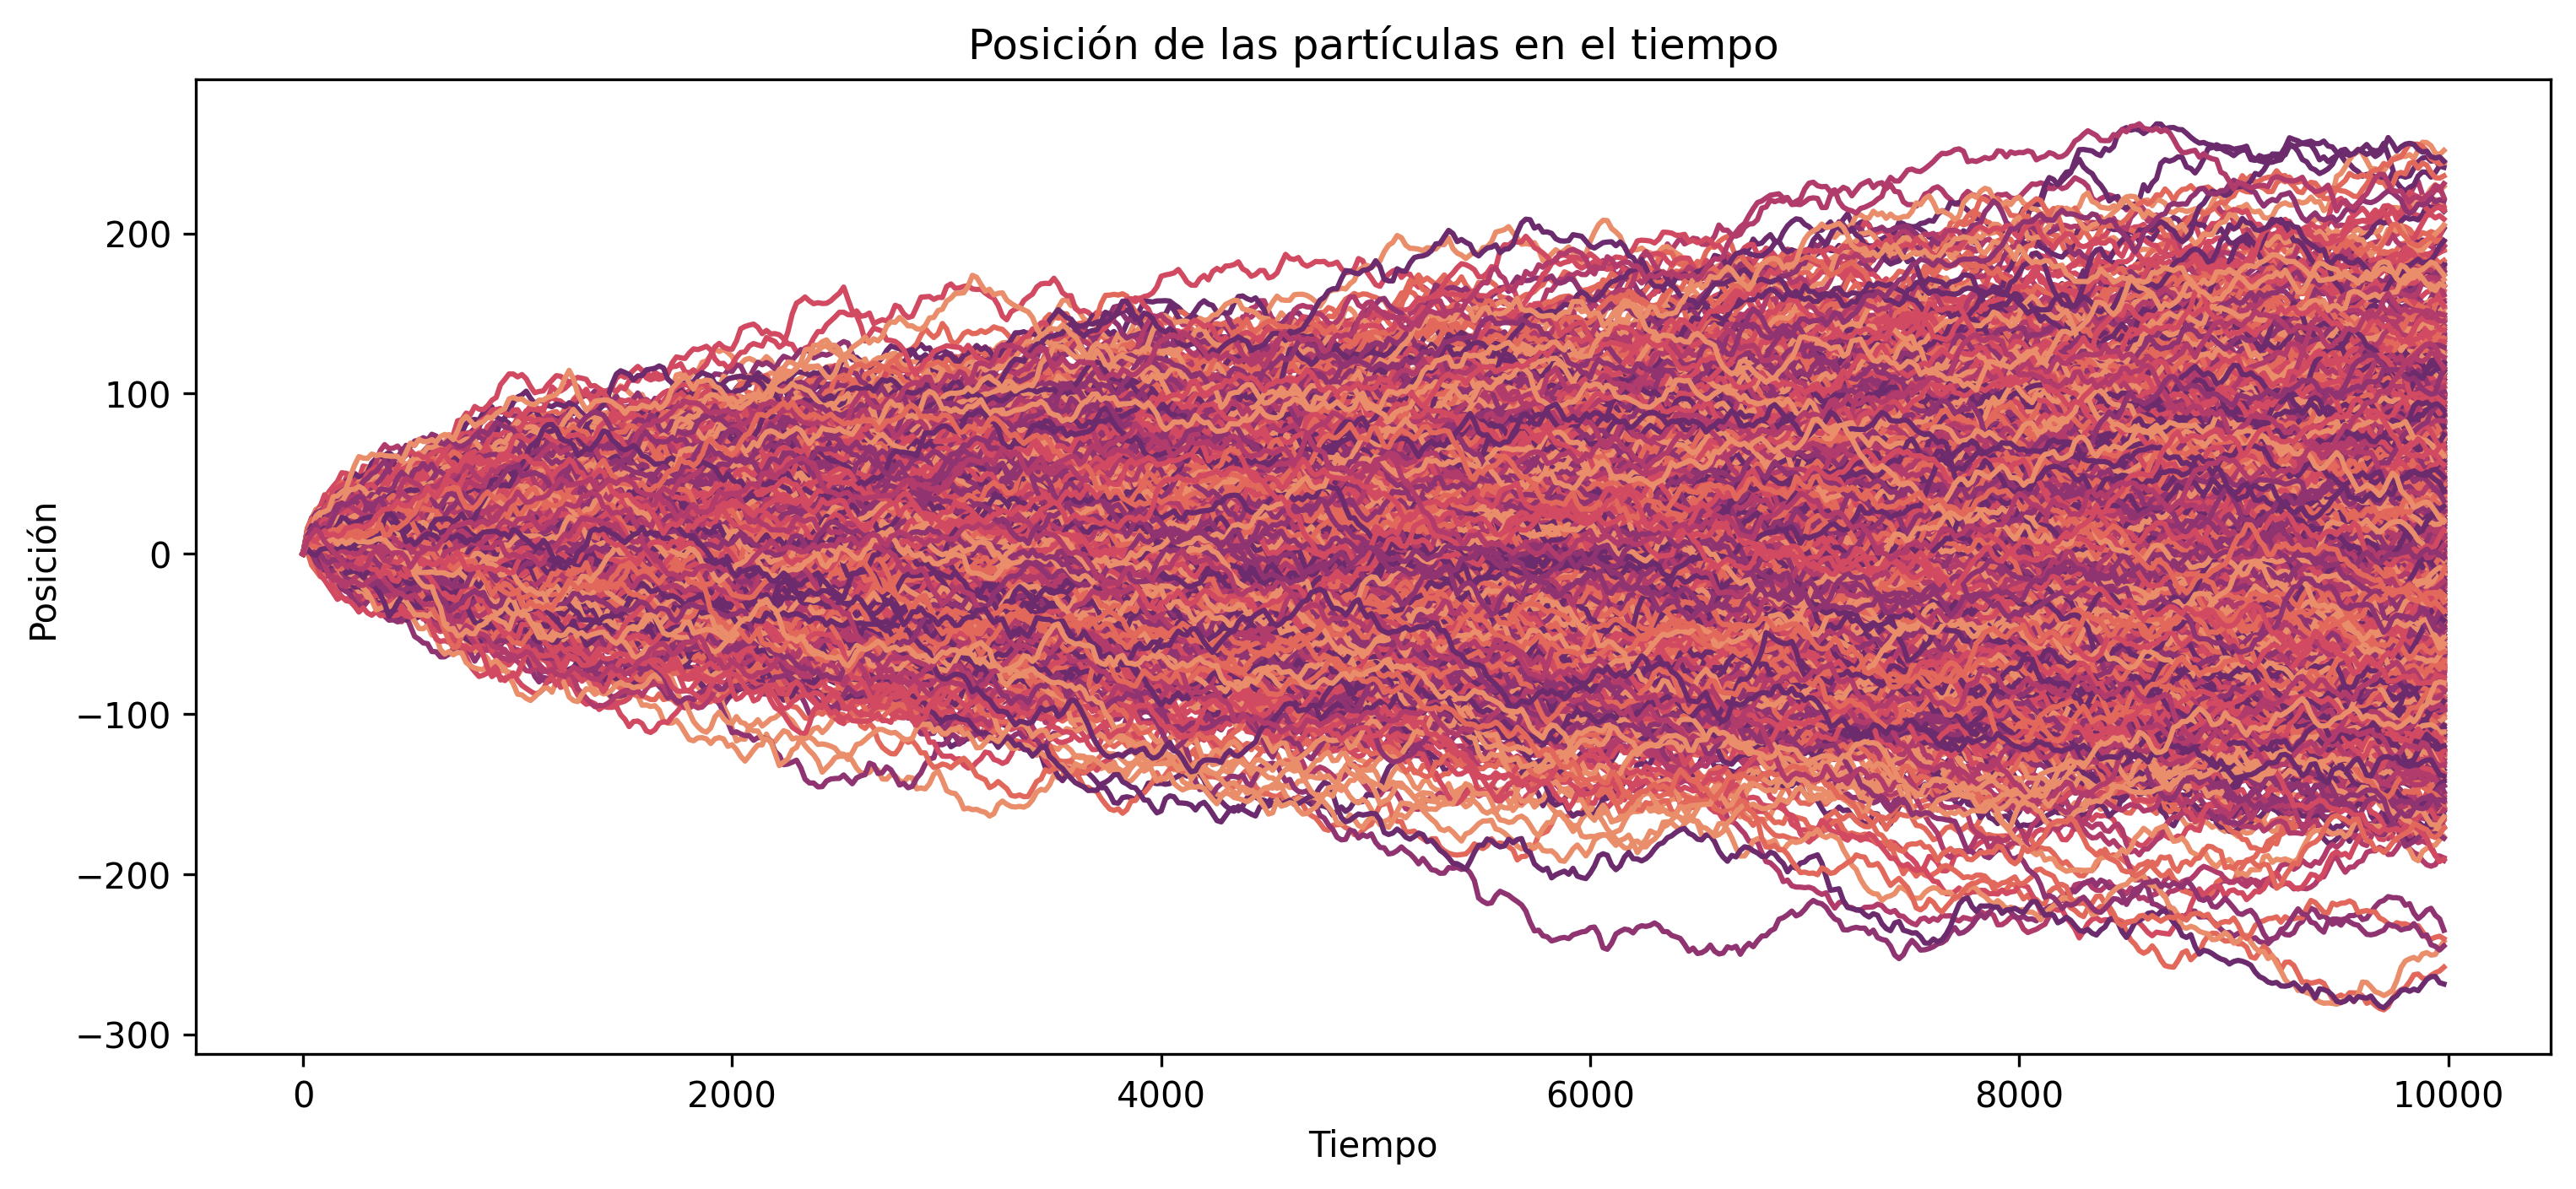

<Figure size 640x480 with 0 Axes>

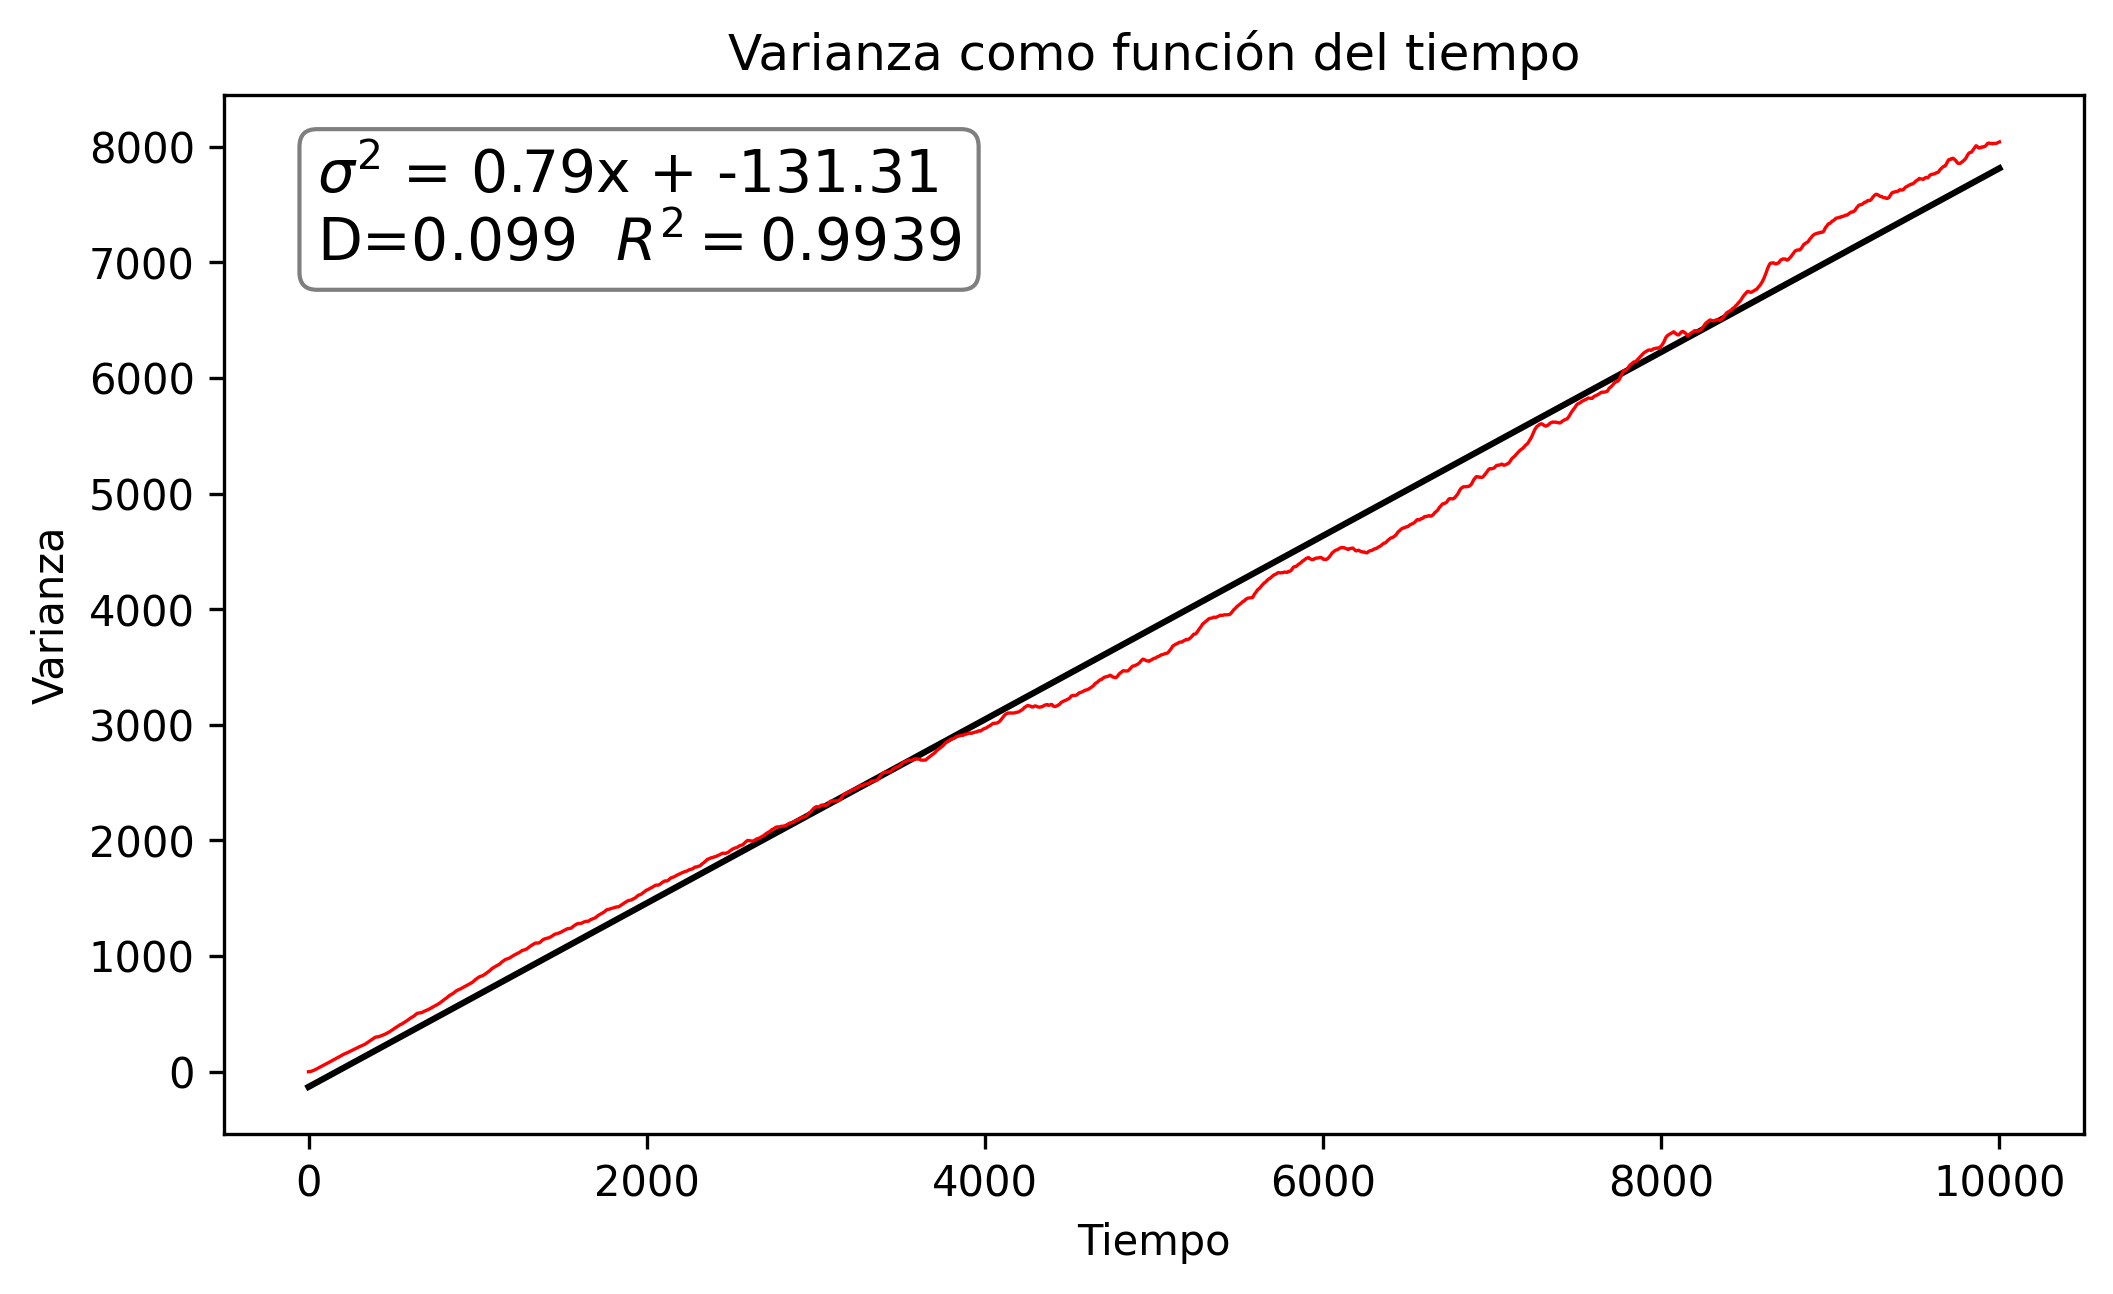

In [37]:
plt.rcParams['text.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'
Sim_3= get_data_pos(1)
t_max_3=Sim_3[1]
files3_x=Sim_3[0]

datos3_x,time3=import_data(files3_x,3,t_max_3)
graph_all_position(datos3_x,time3,200)
particle_positions_3 = np.stack(datos3_x,axis=0)
print(particle_positions_3.shape)
slope, intercept, variance_at_each_time=varianza(particle_positions_3,time3,Sim_3[4])
# plt.clf()




1000.0 1000.0
interval 500
1.9540406259658384e-06 0.0 --- 0 0.0


C:\Users\Usuario\AppData\Local\Temp\ipykernel_12132\157226468.py:35: RuntimeWarning: invalid value encountered in sqrt
  gaussian(np.average(current_position),np.sqrt(slope*real_time+intercept),bins_,N_particles)


1.9540406259658384e-06 0.0 --- 0 0.0
27.248998024235053 40.53561037262173 --- 500 5.0
65.58396027488966 81.07122074524347 --- 1000 10.0
104.09873201391545 121.6068311178652 --- 1500 15.0
143.10799227387645 162.14244149048693 --- 2000 20.0
179.75488515993885 202.67805186310866 --- 2500 25.0
216.960568603271 243.2136622357304 --- 3000 30.0
255.54863074267791 283.7492726083521 --- 3500 35.0
297.43998523319635 324.28488298097386 --- 4000 40.0
332.50524667898725 364.82049335359557 --- 4500 45.0
370.6364435283214 405.3561037262173 --- 5000 50.0
407.7349023061737 445.89171409883903 --- 5500 55.0
450.7599818866864 486.4273244714608 --- 6000 60.0
492.1763493476961 526.9629348440825 --- 6500 65.0
527.7673622569986 567.4985452167042 --- 7000 70.0
574.0047841424665 608.034155589326 --- 7500 75.0
618.6598313153219 648.5697659619477 --- 8000 80.0
658.5585849897318 689.1053763345694 --- 8500 85.0
698.6918437645978 729.6409867071911 --- 9000 90.0
740.9809001836004 770.1765970798128 --- 9500 95.0
784.0

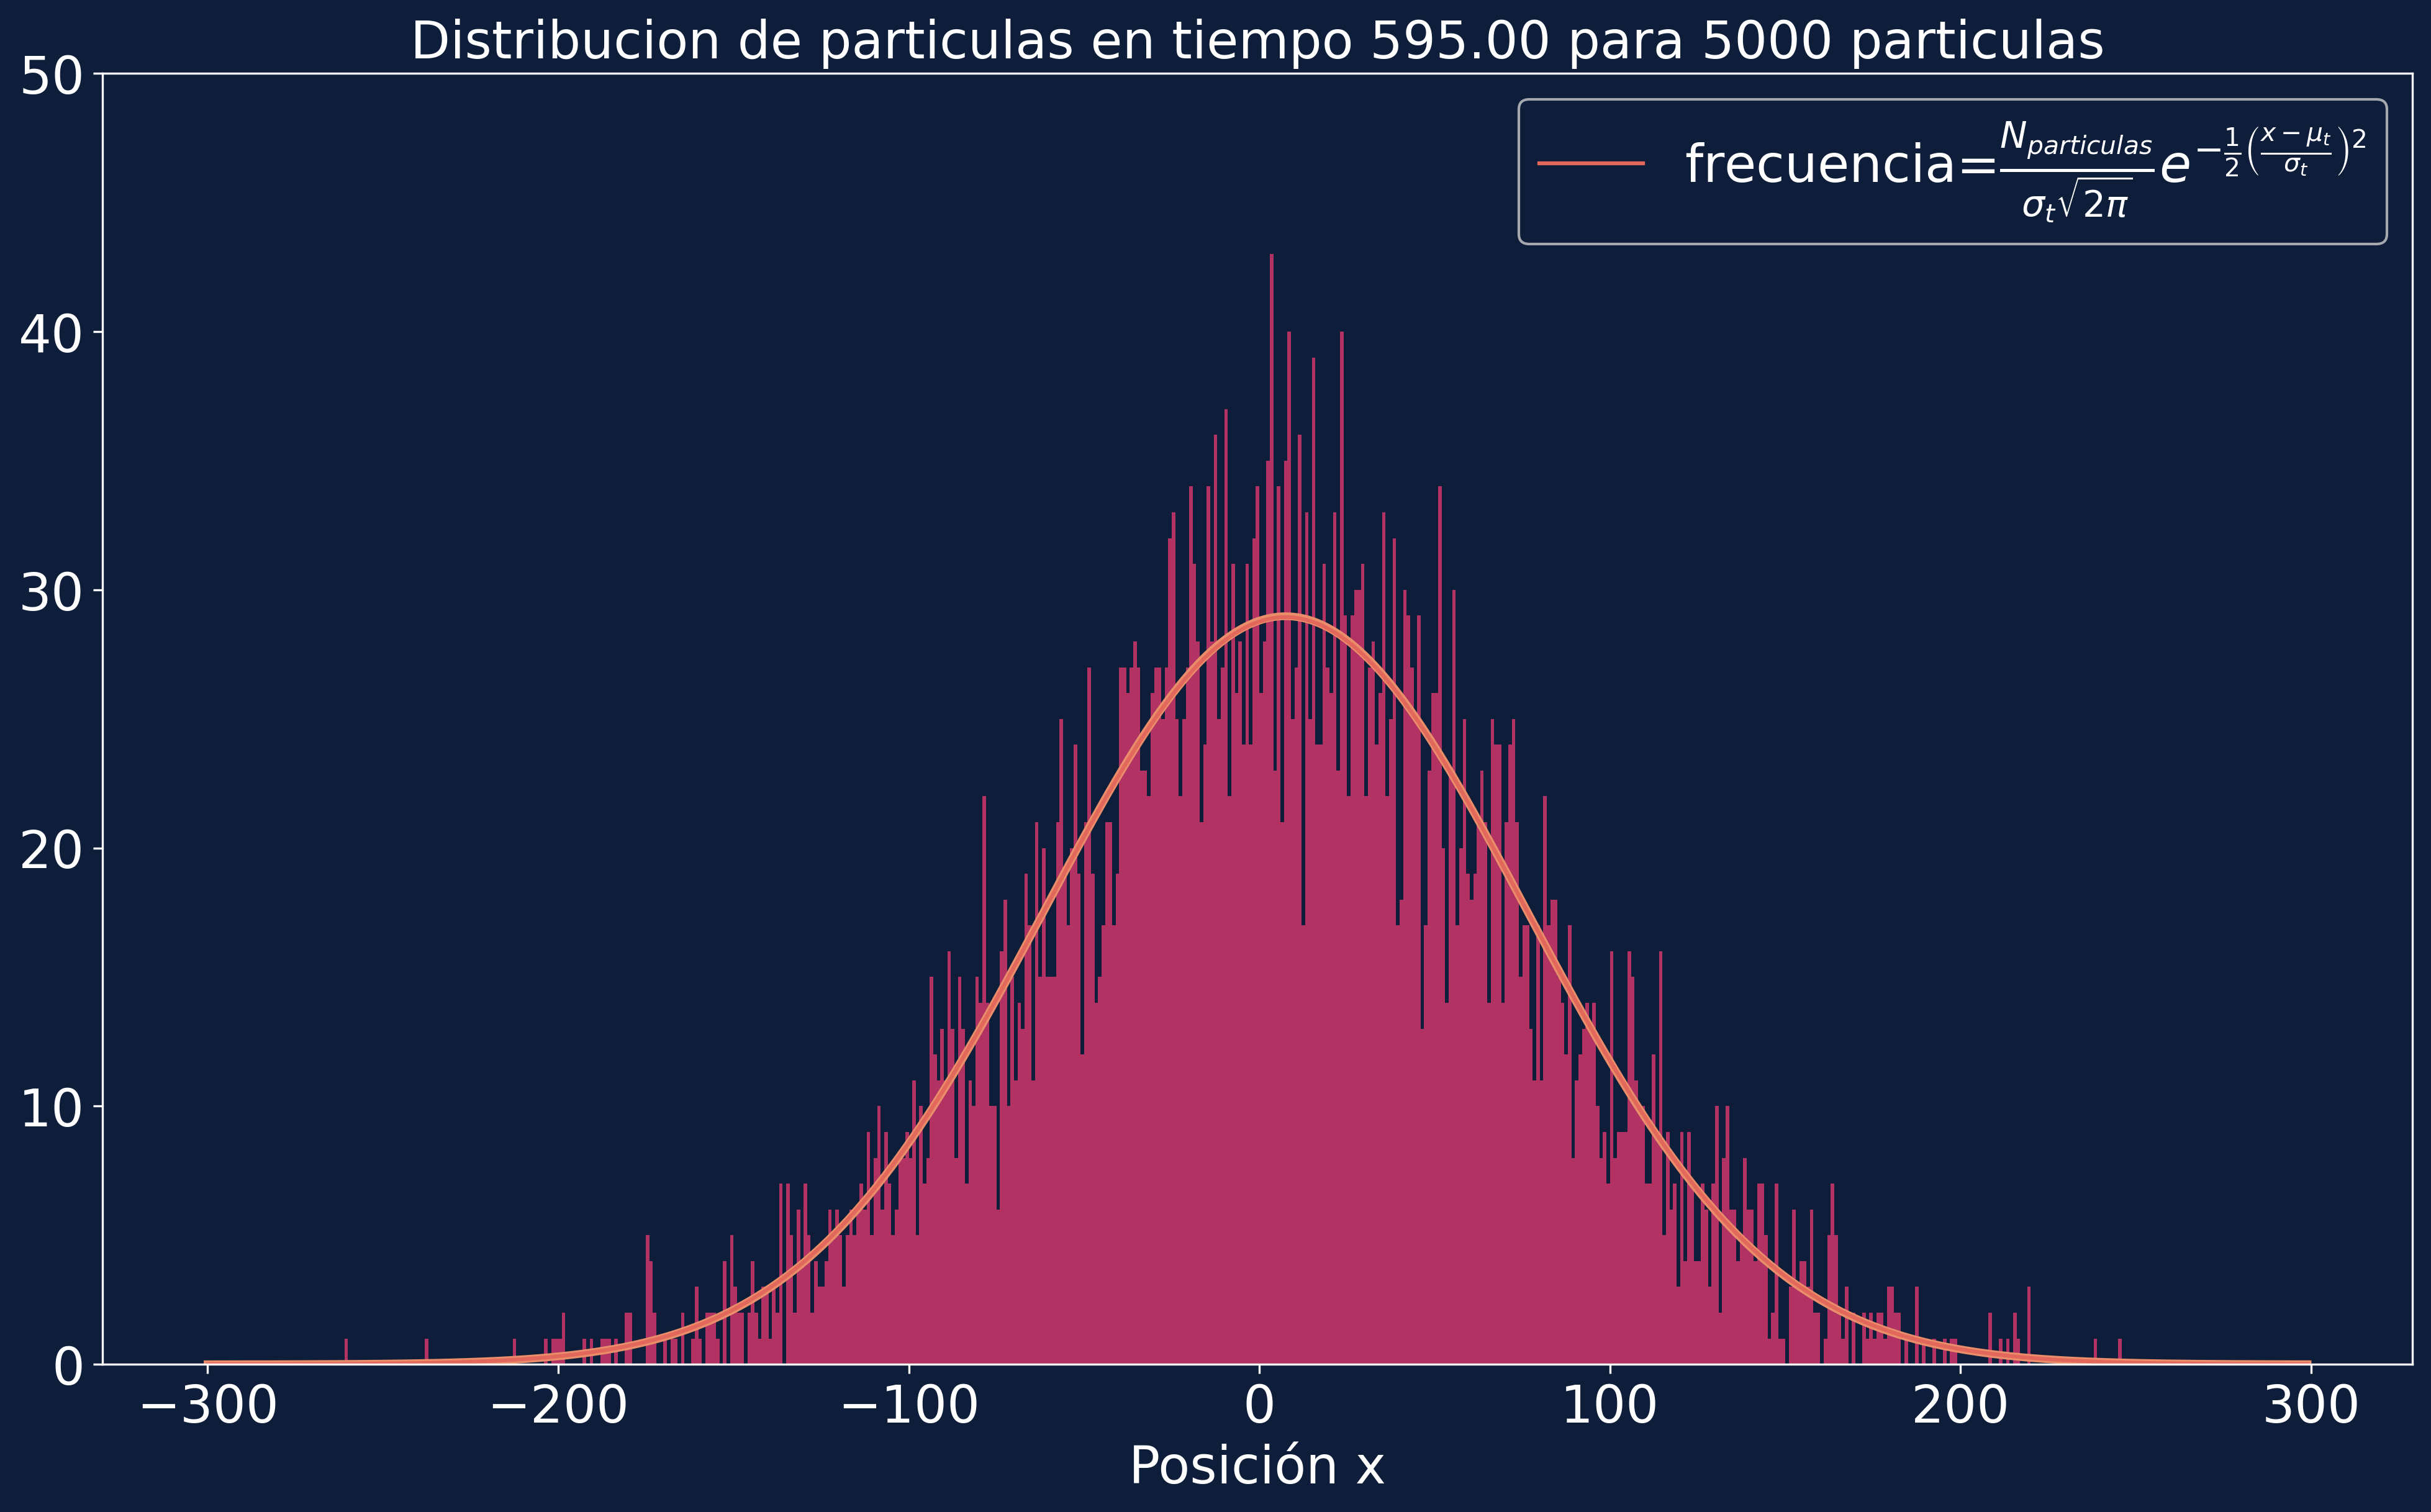

In [ ]:


plt.rcParams['text.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'

fig, ax = plt.subplots()
fig.patch.set_facecolor((14/255,29/255,57/255,255/255))
fig.set_dpi(300)
fig.set_size_inches(16, 9)

for spine in ax.spines.values():
		spine.set_edgecolor('w')
ax.tick_params(colors='w')

bin_size = 1
bins_ = np.arange(-300, 300, bin_size)

frames=120
max_video_time=600
interval=int(max_video_time/(frames*Sim_3[2]))
N_particles=len(particle_positions_3[:, 0])
print(len(time3)*Sim_3[2],t_max_3)
print('interval',interval)
def update(i):

	time_index=i*interval
	real_time=time_index*Sim_3[2]
	current_position=particle_positions_3[:, time_index]
	print(variance_at_each_time[time_index],slope*real_time,'---',time_index,real_time)
	ax.clear()
	ax.hist(current_position, bins=bins_, color=(178/255,51/255,99/255,255/255))
	ax.plot(bins_,
			gaussian(np.average(current_position),np.sqrt(variance_at_each_time[time_index]),bins_,N_particles),
			linewidth=3
			)
	ax.plot(bins_,
			gaussian(np.average(current_position),np.sqrt(slope*real_time+intercept),bins_,N_particles)
			,label=r"frecuencia=$ \frac{N_{particulas}}{\sigma_t \sqrt{2 \pi}}e^{-\frac{1}{2}\left(\frac{x-\mu_t}{\sigma_t} \right)^2  }$"
			
			)
	ax.set_facecolor((14/255,29/255,57/255,255/255))
	ax.set_title(f'Distribucion de particulas en tiempo {real_time:.2f} para {N_particles} particulas',fontsize=20)
	ax.set_xlabel('Posición x',fontsize=20)
	ax.set_ylim(0,50)
	ax.tick_params(colors='w', labelsize=20)
	legend=ax.legend(fontsize=20)
	legend.get_frame().set_facecolor((14/255,29/255,57/255,255/255))

animation = anim.FuncAnimation(fig, update, frames=frames, interval=interval)
animation.save("hist6.mp4", fps=30)
plt.show()

[250.0, 0.01, 10.0, 4.0, 0.05]


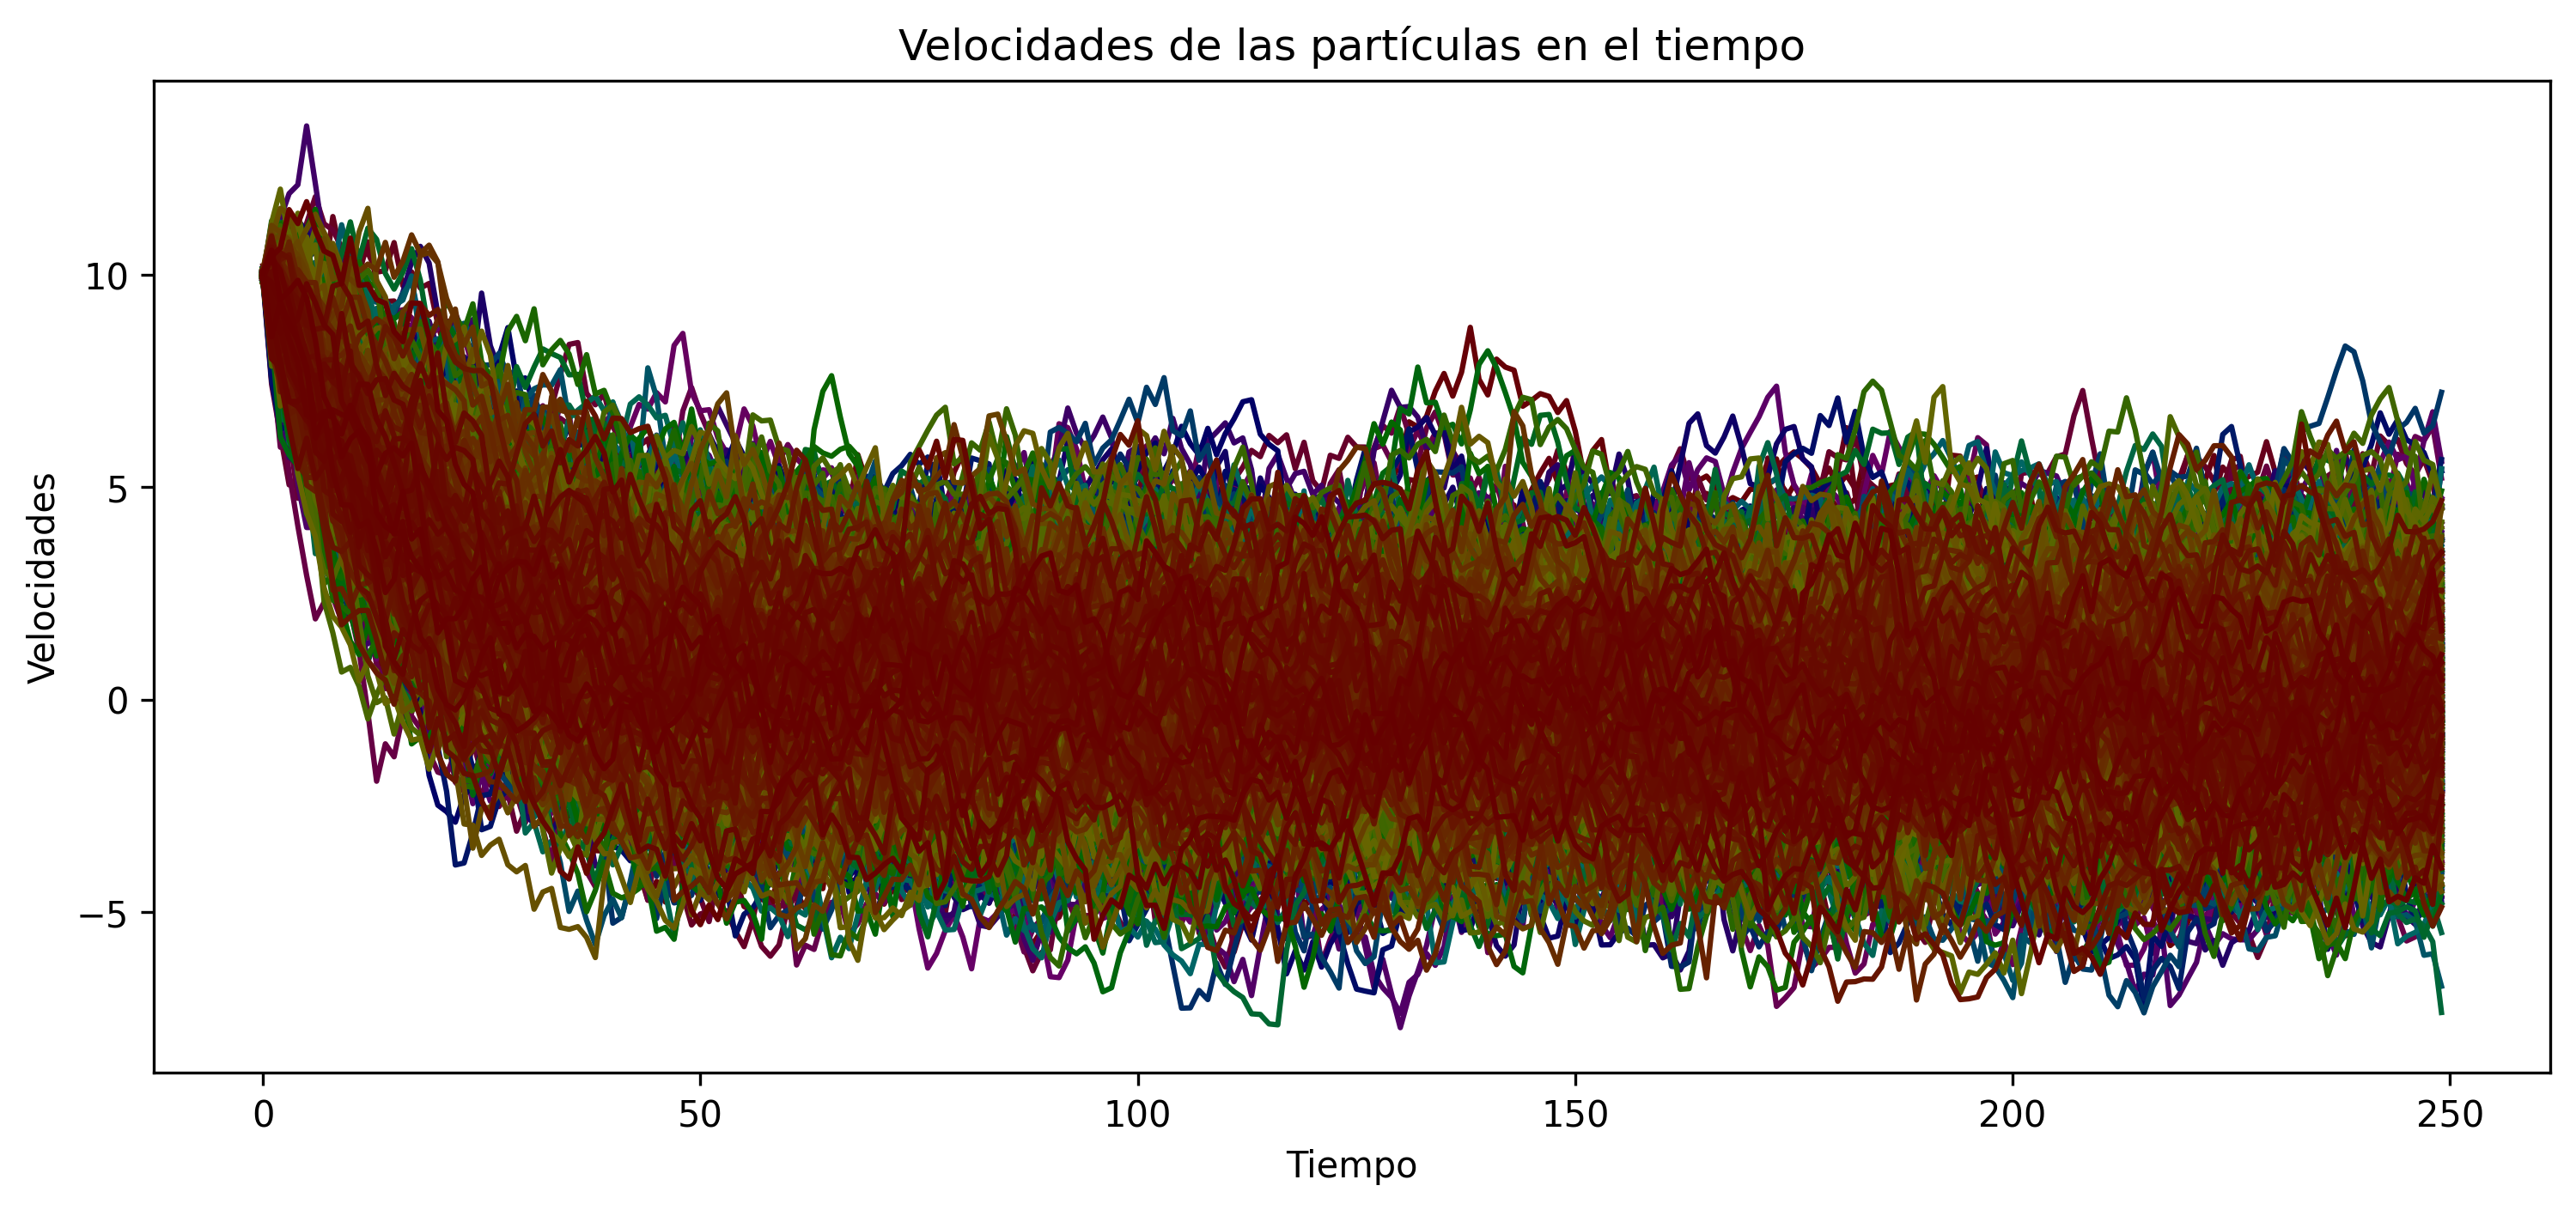

In [4]:
punto_b=get_data_vel(2)
velocities_files=punto_b[0]

velocities_time=punto_b[1]
velocities_dt=punto_b[2]
velocities_V0=punto_b[3]
velocities_T=punto_b[4]
velocities,time_vel=import_data(velocities_files,2,velocities_time,type='velocities')
graph_all_position(velocities,time_vel,100,True,"Velocidades")





C:\Users\Usuario\AppData\Local\Temp\ipykernel_6012\2337097343.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_6012\2337097343.py:2: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x)


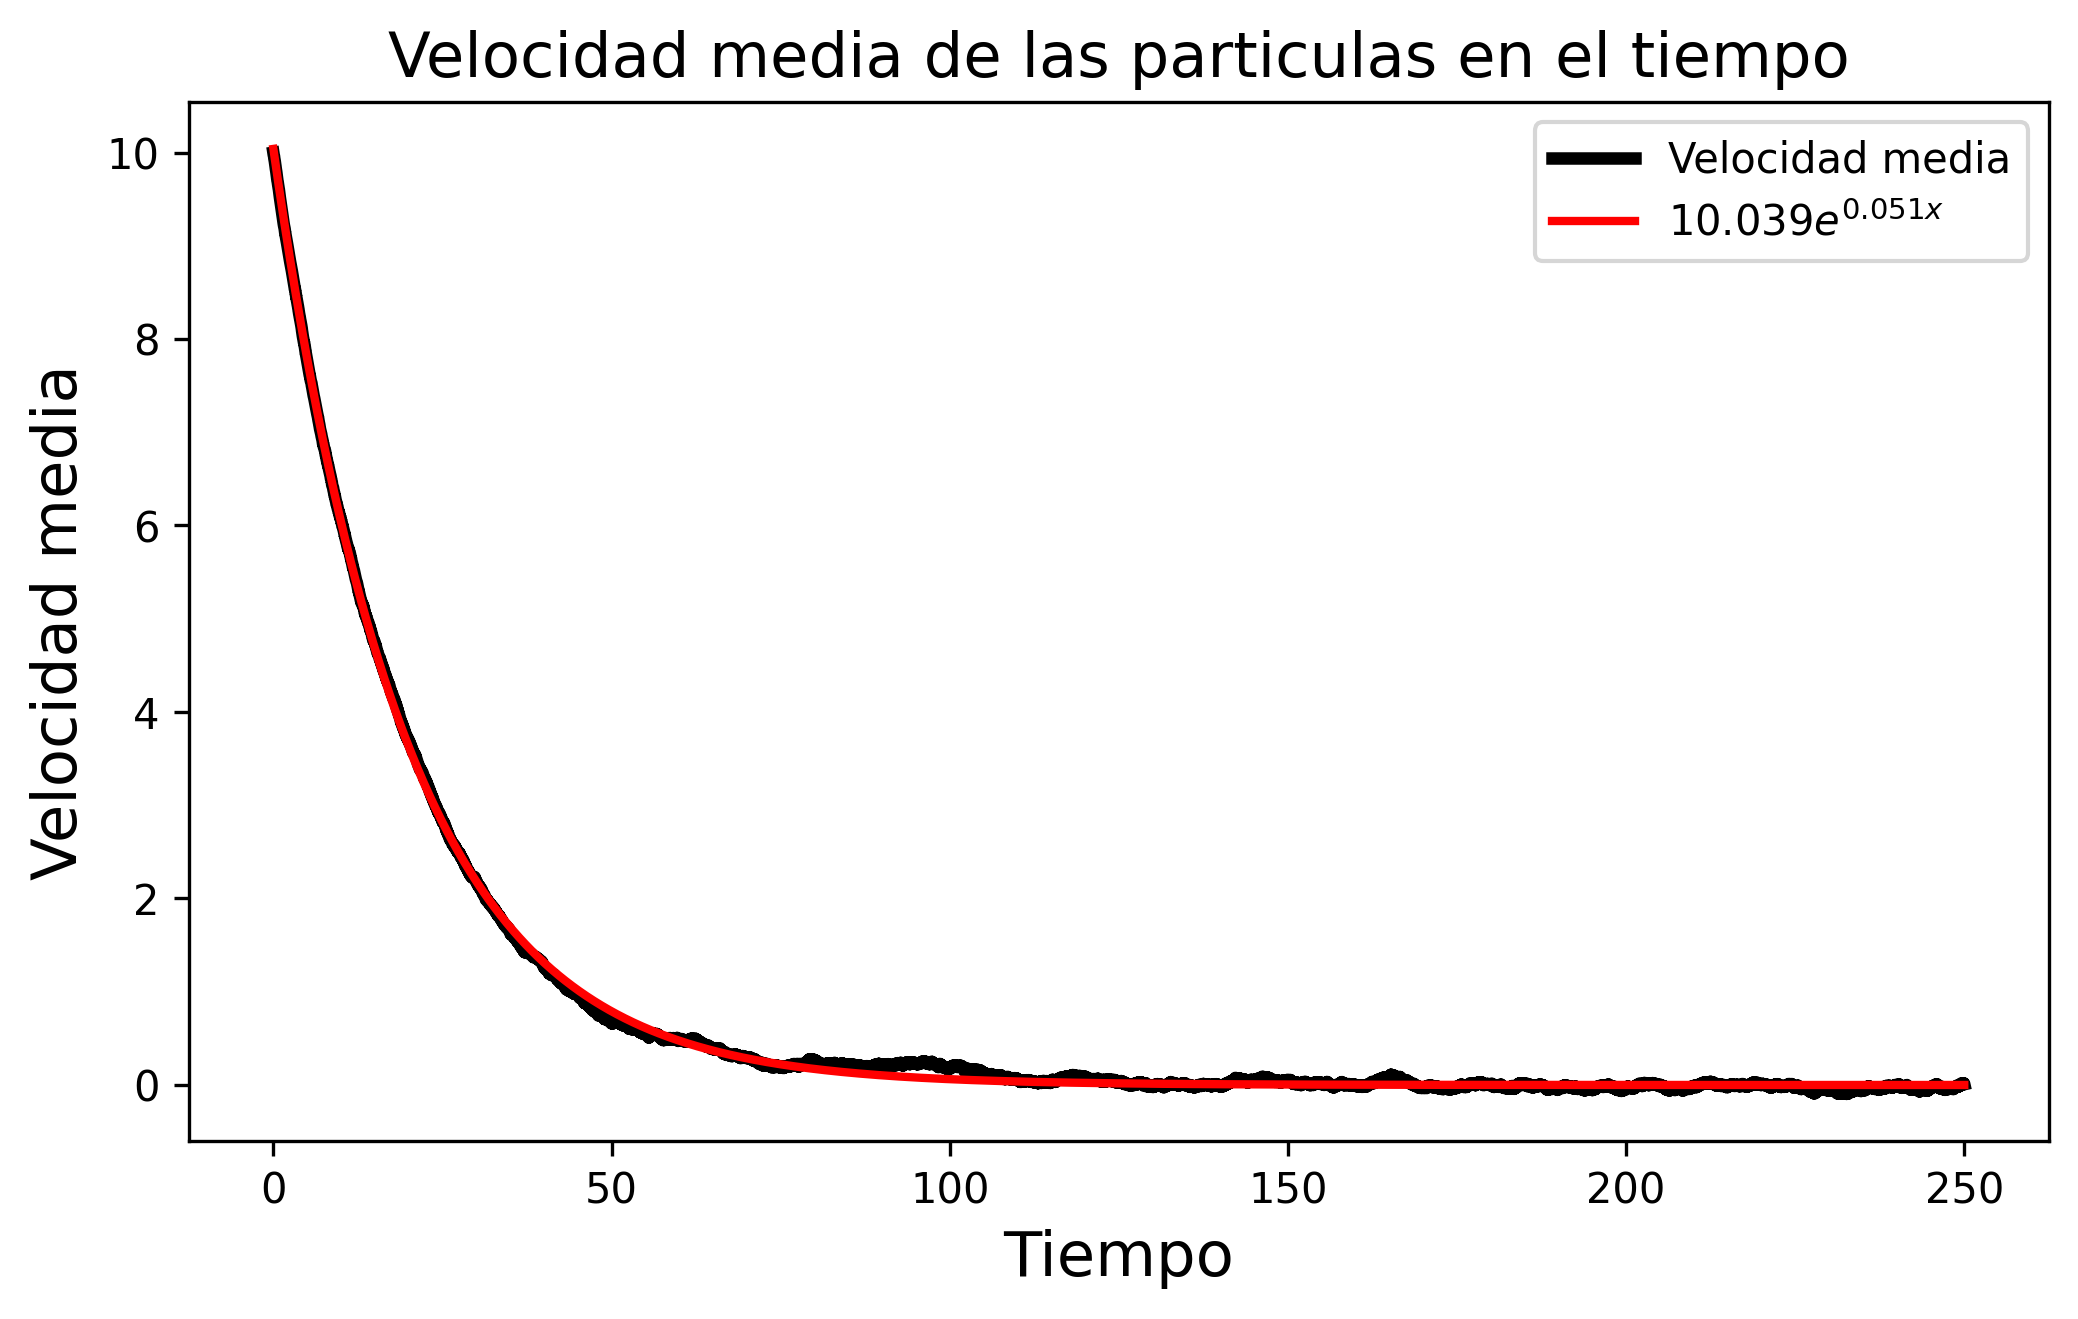

In [10]:
particle_velocities = np.stack(velocities,axis=0)
particle_velocities_avg = np.average(particle_velocities, axis=0)
particle_velocities_std=np.std(particle_velocities,axis=0)

popt, pcov = curve_fit(func_exp, time_vel, particle_velocities_avg)
plt.figure(dpi=300,figsize=(16/2,9/2))
plt.plot(time_vel,particle_velocities_avg,linewidth=3,color='k',label='Velocidad media')
plt.plot(time_vel,func_exp(time_vel,*popt),linewidth=2,color='r',label=f'${popt[0]:.3f}e^{{{popt[1]:.3f}x}}$')
plt.xlabel('Tiempo',fontsize=15)
plt.ylabel('Velocidad media',fontsize=15)
plt.title('Velocidad media de las particulas en el tiempo',fontsize=15)
plt.legend()
plt.tick_params(colors='k', labelsize=10)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_6012\454777980.py:2: RuntimeWarning: overflow encountered in exp
  w=velocities_T*(1-np.exp(-2*g*t))
C:\Users\Usuario\AppData\Local\Temp\ipykernel_6012\454777980.py:2: RuntimeWarning: overflow encountered in multiply
  w=velocities_T*(1-np.exp(-2*g*t))
C:\Users\Usuario\AppData\Local\Temp\ipykernel_6012\454777980.py:3: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(w)


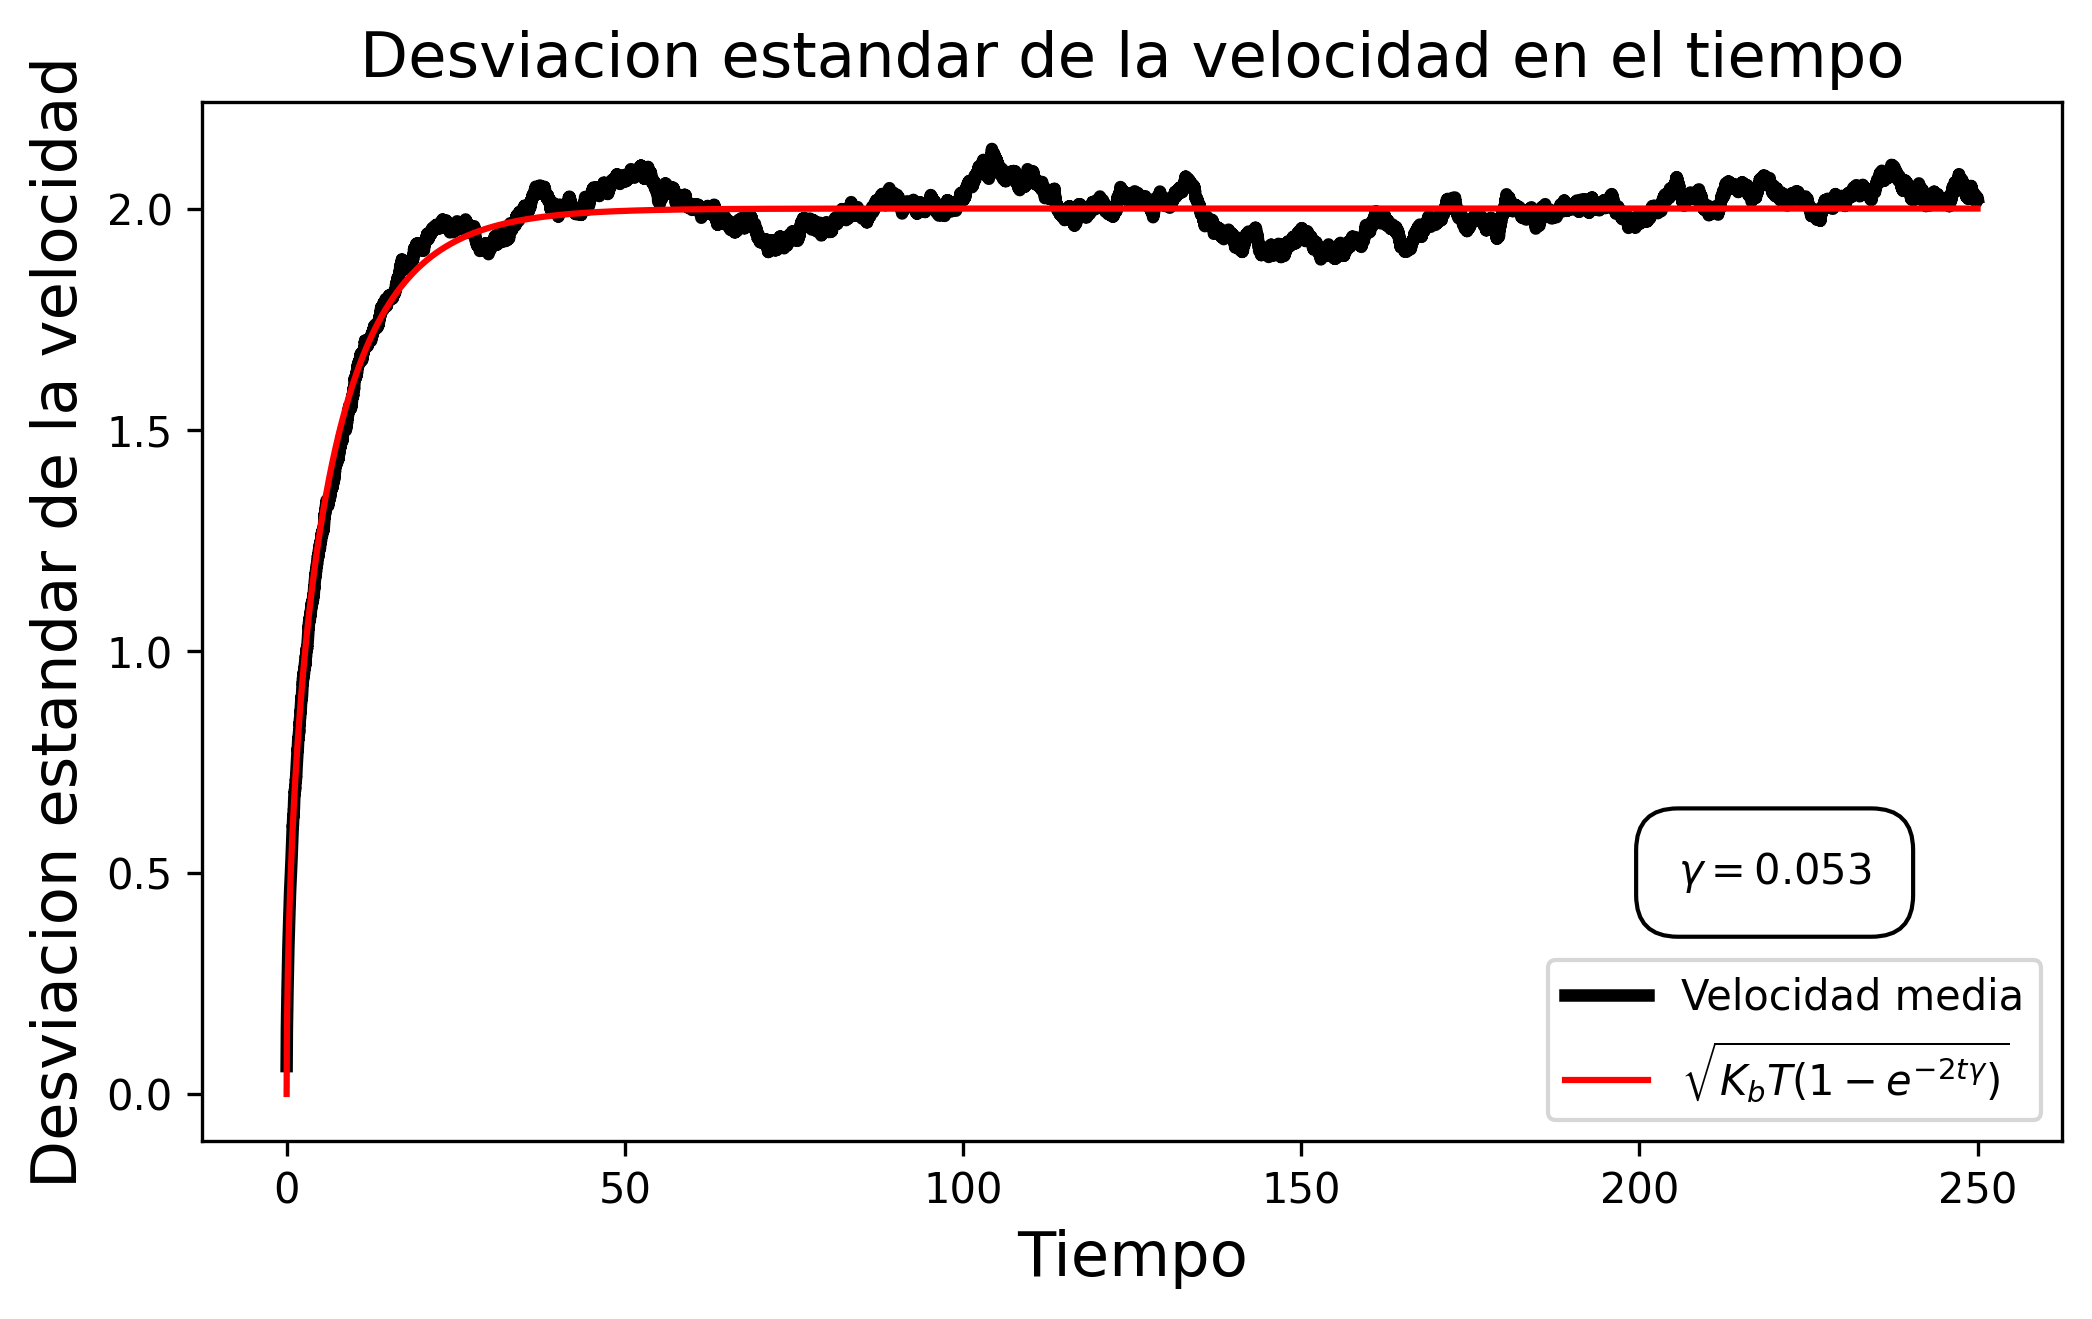

In [36]:
def func_root(t,g):
	w=velocities_T*(1-np.exp(-2*g*t))
	return np.sqrt(w)


popt2, pcov2 = curve_fit(func_root, time_vel, particle_velocities_std)
plt.figure(dpi=300,figsize=(16/2,9/2))
plt.plot(time_vel,particle_velocities_std,linewidth=3,color='k',label='Velocidad media')
plt.plot(time_vel,func_root(time_vel,*popt2),color='r',
		 label=f"$\sqrt{{K_bT(1-e^{{-2t \gamma }})}}$"
		 )
plt.text(220, 0.5, f'$\gamma={popt2[0]:.3f}$', horizontalalignment='center', verticalalignment='center',bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
plt.xlabel('Tiempo',fontsize=15)
plt.ylabel('Desviacion estandar de la velocidad',fontsize=15)
plt.title('Desviacion estandar de la velocidad en el tiempo',fontsize=15)
plt.legend()
plt.tick_params(colors='k', labelsize=10)